# Ticketing system Task

## Import libraries

In [ ]:
!pip install deep-translator
!pip install bertopic

In [16]:
import pandas as pd
import numpy as np
import re
from bs4 import BeautifulSoup
from deep_translator import GoogleTranslator
from transformers import pipeline, BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support,precision_score,recall_score,f1_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from tqdm import tqdm
tqdm.pandas()
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
import json
import spacy
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px
from pprint import pprint
from tqdm import tqdm, tqdm_notebook
from collections import Counter
from wordcloud import WordCloud
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from transformers import BertForSequenceClassification, Trainer, TrainingArguments, TrainerCallback
import torch.nn as nn
import torch.optim as optim

from imblearn.over_sampling import SMOTE
from collections import Counter


## Dataset Exploration

In [3]:
df = pd.read_excel('Book1.xlsx')

In [ ]:
df

,No.,Date,1st-Response Date,Close Date,Request Type,Subject,Status,Priority,Company,Location,Request Detail,Notes,Brand Name,Device Serial Number,Final Cleaned Request Detail,Final Cleaned Notes
0,35209,2022-06-30 14:00:00,2022-06-30 14:08:00,NaT,MOH Central IT General : End User Devices : PC,طلب اصلاح جهاز بعيادة العظام - مستشفى السليل ا...,In Progress/Awaiting Part,Medium,MOH-MIS-Riyadh,Riyadh-Small-Suliel Hopsital,*** This is an external email. Be Vigilant and...,"<note date=""6/30/22 2:18 pm"" author=""a.abdullk...",DELL,DLH0PJ3,*** This is an external email. Be Vigilant and...,السيد منصور تحية طيبة بعد الفحص تبين ان الجهاز...
1,35185,2022-06-30 09:14:00,2022-06-30 09:47:00,NaT,MOH Central IT General : Other,إعادة توجيه: إعادة توجيه: احتياج المستشفى من ا...,In Progress,Medium,MOH-MIS-Riyadh,Riyadh-Tele-Hotet bani Sudair,*** This is an external email. Be Vigilant and...,"<note date=""6/30/22 9:47 am"" author=""m.ezzat@c...",Null,Null,"abdulmalek _ Sent: Sunday, March 27, 2022 10:...",السلام عليكم ورحمة الله وبركاته السادة الكرام ...
2,35182,2022-06-30 07:53:00,2022-06-30 08:08:00,NaT,MOH Central IT General : Network : New Network...,انشاء 10 نقاط جديدة بشكل عاجل,In Progress,Medium,MOH-MIS-Riyadh,Riyadh-Advanced-North Riyadh Hospital,*** This is an external email. Be Vigilant and...,NaN,Null,Null,*** This is an external email. Be Vigilant and...,nan
3,35163,2022-06-29 12:00:00,2022-06-29 12:02:00,NaT,MOH Central IT General : End User Devices : PC,PC BROBLEM,In Progress,Medium,MOH-MIS-Riyadh,Riyadh-Medium-King Salman Hospital,*** This is an external email. Be Vigilant and...,"<note date=""6/29/22 12:02 pm"" author=""m.ezzat@...",Null,BL6ZQZI,*** This is an external email. Be Vigilant and...,assigned to Eng. abdulalkhaliq 0507476087
4,35158,2022-06-29 11:17:00,2022-06-29 11:27:00,2022-06-30 13:30:00,MOH Central IT General : Security : Kaspersky,تحديث برنامج كاسبر _مستشفى شقراء العام,Closed,Medium,MOH-MIS-Riyadh,Riyadh -Small-Shaqraa Hospital,*** This is an external email. Be Vigilant and...,"<note date=""6/29/22 12:01 pm"" author=""Omar.Muk...",Null,Null,*** This is an external email. Be Vigilant and...,"Hello Dear, Please provide mobile number. Rega..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1058,27555,2022-01-02 12:01:00,2022-01-02 12:02:00,2022-01-14 16:43:00,MOH Central IT General : Security : Firewall :...,اضافة IP على DNS الخاص بمستشفى الرس العام,Closed,Medium,MOH-MIS-Qassim,Qassim-medium-Alrass Hospital,اتاحة خاصية لتمكنا من الدخول على DNS الخاص بال...,"<note date=""1/20/22 7:59 pm"" author=""wd.mutasi...",NaN,NaN,اتاحة خاصية لتمكنا من الدخول على DNS الخاص بال...,تم إضافة العناوين التالية على سيرفر توزيع العن...
1059,27545,2022-01-02 11:27:00,2022-01-02 11:39:00,2022-01-05 20:57:00,MOH Central IT General : End User Devices : Pr...,عطل بطابعة قسم القانونية والاتزام,Closed,Medium,MOH-MIS-Qassim,Qassim-medium-Alrass Hospital,طابعة متعطله بقسم القانونية والالتزام_x000D__x...,"<note date=""1/4/22 8:52 pm"" author=""rashid.hus...",HP,vnc4359064,طابعة متعطله بقسم القانونية والالتزام اسم الطا...,السادة مستشفى الرس المحترمين تحية طيبة نفيدكم ...
1060,27540,2022-01-02 10:38:00,2022-01-02 10:40:00,2022-01-03 13:41:00,MOH Central IT General : End User Devices : Pr...,طابعه لاتعمل,Closed,Medium,MOH-MIS-Qassim,Qassim-small-Albekeryah Hospital,السادة شركة المعمر المحترمين_x000D...,"<note date=""1/2/22 10:45 am"" author=""rashid.hu...",Null,Null,السادة شركة المعمر المحترمين السلام عليكم ورحم...,السادة مستشفى البكيرية المحترمين تحية طيبة جار...
1061,27533,2022-01-02 09:57:00,2022-01-02 09:58:00,2022-01-03 15:17:00,MOH Central IT General : Security : Firewall :...,مشكله برنامج العيادة الافتراضيه والبرامج الاداريه,Closed,Medium,MOH-MIS-Riyadh,Riyadh-Tele-Wathelan Hospital,السلام عليكم ورحمة الله وبركاته_x000D__x000D_ا...,"<note date=""1/2/22 3:16 pm"" author=""Omar.Mukht...",NaN,NaN,السلام عليكم ورحمة الله وبركاته السادة شركة ال...,السلام عليكم ورحمة الله تحيه طيبه كما ناقشنا ف...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1063 entries, 0 to 1062
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   No.                   1063 non-null   int64         
 1   Date                  1063 non-null   datetime64[ns]
 2   1st-Response Date     1063 non-null   datetime64[ns]
 3   Close Date            943 non-null    datetime64[ns]
 4   Request Type          1063 non-null   object        
 5   Subject               966 non-null    object        
 6   Status                1063 non-null   object        
 7   Priority              1063 non-null   object        
 8   Company               1063 non-null   object        
 9   Location              1063 non-null   object        
 10  Request Detail        1063 non-null   object        
 11  Notes                 1045 non-null   object        
 12  Brand Name            755 non-null    object        
 13  Device Serial Numb

In [7]:
# show null in each column

df.isnull().sum()


,0
No.,0
Date,0
1st-Response Date,0
Close Date,120
Request Type,0
Subject,97
Status,0
Priority,0
Company,0
Location,0


In [5]:
# replace null notes with ''

df['Notes'].fillna('', inplace=True)


## Data Cleaning


### 1. Clean Requests column

In [ ]:
# print five random samples from request details column full text in a clean way

for i in range(20):
  print(repr(df['Request Detail'].sample(1).values[0]))
  print('-' * 50)


"Dear MIS Support team ,_x000D__x000D__x000D__x000D_We have a problem with printer (  doesn't  work)_x000D__x000D_Serial Number : XFA43257_x000D_Hardware Model : CANON MF_x000D_Device Location :ER_x000D_Issue description :  doesn't  work_x000D__x000D_Hospital Name :     Al-Quwayiyah Hospital_x000D_Contact Mobile Number :    Sultan Al Shehri  |    0556689618_x000D__x000D__x000D__x000D__x000D__x000D__x000D__x000D_????? ?????? ?????????: ??? ??????? ????????? ???? ???????? ???????? ???? ??????? ???????? ??? ? ?? ????? ??? ??????? ???? ?? ????? ???????. ?? ?? ??? ????? ???????? ???? ????? ???? ???? ?? ??? ?? ??? ?? ??????? ??? ???? ?? ???????. ???? ????? ???????? ?? ???? ???? ??? ??? ?????? ?????????? ?????? ???? ????? ???????? ????. ??? ????????? ? ?????? ???????? ?? ??????? ???? ????????? ? ?? ???? ????? ?????. ??? ?? ????? ??????? ??????? ??????? ??????? ?? ?? ??????? ?? ?????? ??? ???????._x000D__x000D_CONFIDENTIALITY NOTICE: This e-mail message, including any attachments, is for the s

Based on the 20 samples you provided, the following irrelevant information should be removed to focus on the content of the emails:

**1. Confidentiality Notices:**
- Example:
  - "تنبيه بإخلاء المسئولية: هذه الرسالة ومرفقاتها معدة لاستخدام المُرسَل إليه..."
  - "CONFIDENTIALITY NOTICE: This e-mail message, including any attachments..."

**2. Formatting Artifacts:**
- Example:
  - `_x000D_`, `_x000A_`, `_x0003_`
  - `[cid:image001.png@...]`
  - `[1650871122279]`

**3. Attachment References:**
- Example:
  - `[attachment name=IMG_3976.jpg]`
  - `[cid:image001.png@...]`
  - `[attachment name=OutlookEmoji-1588248001736...]`

**4. HTML Tags or Email Signatures:**
- Example:
  - "‫أُرسلت من الـ iPhone‬"
  - "Eng. Meaad Al Junainy"
  - "Waleed Abdullah Alotaibi"

**5. Repeated Newlines or Spacing:**
- Example:
  - `______________`
  - `______` (repeated underscores)

**6. Contact Information (Potentially Sensitive):**
- Example:
  - "Contact Number: 0530390003"
  - "Eng. Meaad Al Junainy 0538622033"
  - "Email addresses like donia.alzayer@ge.com"

**7. External Email Notices:**
- Example:
  - External Email Notices: Phrases like "This is an external email. Be Vigilant and take precautions."

**8. Greetings and Formalities:**
- Example:
  - Phrases such as "Dear XX," "السلام عليكم," or "تحية طيبة" are standard greetings or pleasantries commonly found in emails.



Next, we define a function to clean the email content by removing unnecessary information.

In [6]:

# Enhanced cleaning function to remove greetings, external email notices, confidentiality, and other irrelevant info
def clean_request(text):

    # Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()

    # Remove external email notices
    text = re.sub(r'\*\*\*.*?\*\*\*', '', text)

    # Remove greetings and formalities like "Dear XX" and "السلام عليكم"
    text = re.sub(r'(Dear\s\w+|تحية طيبة|Hello)', '', text)
    text = re.sub(r'(السلام عليكم ورحمة الله وبركاته)', '', text)
    text = re.sub(r'(السلام عليكم ورحمة الله)', '', text)
    text = re.sub(r'(السلام عليكم)', '', text)

    # Remove formatting artifacts like _x000D_ and similar patterns
    text = re.sub(r'_x[0-9A-Fa-f]{4}_', ' ', text)

    # Remove sent from iphone tag
    text = re.sub(r'\u202b(.*?)\u202c', '', text)
    text = re.sub(r'أرسلت من الiPhone', '', text)
    text = re.sub(r'أُرسلت من الiPhone', '', text)


    # Remove repeated "_"
    text =  re.sub(r'_+', '', text)


    # Remove attachment references such as [attachment name=IMG_3976.jpg] and similar patterns
    text = re.sub(r'\[*?\]', '', text)

    text = re.sub(r'[^\w\s:]', '', text)


    # Remove confidentiality notices in both Arabic and English
    text = re.sub(r'(CONFIDENTIALITY NOTICE|تنبيه بإخلاء المسئولية).*', '', text, flags=re.DOTALL)

    # Remove contact information patterns like phone numbers and email addresses
    text = re.sub(r'\b\d{9,}\b|\b[\w.-]+?@[\w.-]+?\.\w+?\b', '', text)

    # Remove multiple spaces or newlines
    text = re.sub(r'\s+', ' ', text)

    # Remove leading and trailing spaces
    return text.strip()

# Apply this cleaning to the 'Request Detail' and 'Notes' columns
df['Cleaned Request Detail'] = df['Request Detail'].astype(str).apply(clean_request)


In [12]:
# show the same 5 samples before and after cleaning

samples = df['Request Detail'].sample(5).index

for index in samples:
  print("Original Request Detail:")
  print(df.loc[index, 'Request Detail'])
  print("\nCleaned Request Detail:")
  print(df.loc[index, 'Cleaned Request Detail'])
  print("\n---\n")


Original Request Detail:
Device Information:_x000D_Keyboard_x000D_device brand name_x000D_Hp or any_x000D__x000D_device issue_x000D_Damaged mouse want to replace_x000D__x000D_  Contact information:_x000D_Waleed_x000D_  contact number:_x000D_0530390003<tel:0530390003>_x000D_  name of the hospital:_x000D_AFIF GENERAL HOSPITAL_x000D__x000D__x000D_وليد عبدالله العتيبي_x000D_مستشفى عفيف العام_x000D_شركة المعمر لأنظمة المعلومات_x000D_0530390003_x000D__x000D__x000D__x000D__x000D__x000D_تنبيه بإخلاء المسئولية: هذه الرسالة ومرفقاتها معدة لاستخدام المُرسَل إليه المقصود بالرسالة فقط و قد تحتوي على معلومات سرية أو محمية قانونيا. إن لم تكن الشخص المقصود، فإنه يُمنع منعا باتا أي عرض أو نشر أو استخدام غير مصرح به للمحتوى. نرجو إخطار المُرسِل عن طريق الرد على هذا البريد الإلكتروني وإتلاف جميع النسخ الموجودة لديك. تعد التصريحات و الآراء المذكورة في الرسالة خاصة بالمُرسِل و لا تمثل وزارة الصحة. كما لا تتحمل الوزارة مسؤولية الأضرار الناتجة عن أي فيروسات قد تحملها هذه الرسالة._x000D__x000D_CONFIDENTIALITY

### 2. Clean Notes column

In [ ]:
# print five random samples from request details column full text in a clean way

for i in range(20):
  print(df['Notes'].sample(1).values[0])
  print('-' * 50)


<note date="2/20/22 8:50 am" author="sara.albakheet@ccs.com.sa" type="tech" time="0" rate="">Assigned to Eng Ahmad 0590801209</note>_x000D_<note date="2/20/22 9:52 am" author="Ahmed.Swalmeh@ccs.com.sa" type="tech" time="0" rate="">Dear Eng. Fawaz _x000D__x000D_As discussed over the phone with Eng. Khalid, he advice that the network is stable now and he solved the issue _x000D__x000D_Feel free to open a new case for any support _x000D__x000D__x000D__x000D_Regards_x000D_Ahmed Swalmeh_x000D_Network Engineer_x000D_00966590801209</note>
--------------------------------------------------
<note date="5/24/22 8:50 am" author="sara.albakheet@ccs.com.sa" type="tech" time="0" rate="">assigned to Eng. abdulalkhaliq 0507476087      </note>_x000D_<note date="6/28/22 10:10 pm" author="A.Javed@ccs.com.sa" type="tech" time="0" rate="">Checked and found the Adf is not loading paper_x000D_Adf sapration pad is broken</note>
--------------------------------------------------
nan
---------------------------

The original text provided is structured like an XML or HTML tag, with each note enclosed in a <note> tag. The attributes of the <note> tag provide metadata (such as date, author, type, etc.), while the content inside the tag contains the actual note or message. Many notes contain `Assigned to Eng..`. We will ignore this kind of notes.

In [7]:

def clean_notes_column(text):
    # Parse the HTML content and extract notes
    soup = BeautifulSoup(text, "html.parser")

    # Extract all <note> tags
    notes = soup.find_all('note')

    # Process each note individually
    cleaned_notes = []
    for note in notes:

        # Extract the text within the note tag
        note_text = note.get_text()

        # Discard notes containing "assigned to"
        if 'assigned to' in note_text.lower():
            continue

        # Remove unwanted tokens like _x000D_
        note_text = re.sub(r'_x[0-9A-Fa-f]{4}_', ' ', note_text)

        # Remove external email notices
        note_text = re.sub(r'\*\*\*.*?\*\*\*', '', note_text)

        # Remove greetings like "Dear" or "السلام عليكم"
        # Remove greetings and formalities like "Dear XX" and "السلام عليكم"
        note_text = re.sub(r'(Dear\s\w+|تحية طيبة|Hello)', '', note_text)
        note_text = re.sub(r'(السلام عليكم ورحمة الله وبركاته)', '', note_text)
        note_text = re.sub(r'(السلام عليكم ورحمة الله)', '', note_text)
        note_text = re.sub(r'(السلام عليكم)', '', note_text)
        # Remove contact information (phone numbers, emails)
        note_text = re.sub(r'\b\d{9,}\b|\b[\w.-]+?@[\w.-]+?\.\w+?\b', '', note_text)

        # Remove extra whitespace or newlines
        note_text = re.sub(r'\s+', ' ', note_text).strip()

        # Remove sent from iphone tag
        note_text = re.sub(r'\u202b(.*?)\u202c', '', note_text)
        note_text = re.sub(r'أرسلت من الiPhone', '', note_text)
        note_text = re.sub(r'أُرسلت من الiPhone', '', note_text)

        # Remove repeated "_"
        text =  re.sub(r'_+', '', text)

        # Remove confidentiality notices in both Arabic and English
        note_text = re.sub(r'(CONFIDENTIALITY NOTICE|تنبيه بإخلاء المسئولية).*', '', note_text, flags=re.DOTALL)

        # Remove all punctuation except ':'
        note_text = re.sub(r'[^\w\s:]', '', note_text)


        # Remove multiple spaces or newlines
        note_text = re.sub(r'\s+', ' ', note_text)


        # Append the cleaned note
        cleaned_notes.append(note_text)

    # Join all cleaned notes into a single string
    return ' | '.join(cleaned_notes)

# Apply the cleaning function to the 'Notes' column
df['Cleaned Notes'] = df['Notes'].astype(str).apply(clean_notes_column)

In [ ]:
# show 20 pairs of samples after cleaning

samples = df['Notes'].sample(20).index

for index in samples:
  print("Cleaned Request:")
  print(df.loc[index, 'Cleaned Request Detail'])
  print("\nCleaned Notes:")
  print(df.loc[index, 'Cleaned Notes'])
  print("\n---\n")


## Translation

Translation is important to ensure that both Arabic and English content can be uniformly processed for analysis, allowing for consistent insights and accurate model training across multilingual datasets. It bridges language gaps, enabling better classification, labeling, and overall comprehension of the data.

Before performing translation, it’s important to analyze the length of the cleaned text in the `Notes` and `Request Detail` fields. This helps us understand the structure of the data and decide whether any excessively long records should be removed before translation.

Descriptive statistics for Cleaned Notes Length:
count    1063.000000
mean      304.151458
std       419.464654
min         0.000000
25%        93.000000
50%       200.000000
75%       343.500000
max      5029.000000
Name: Cleaned Notes Length, dtype: float64

Descriptive statistics for Cleaned Request Detail Length:
count    1063.000000
mean      336.668862
std       765.708657
min        10.000000
25%       112.500000
50%       213.000000
75%       297.500000
max      9264.000000
Name: Cleaned Request Detail Length, dtype: float64


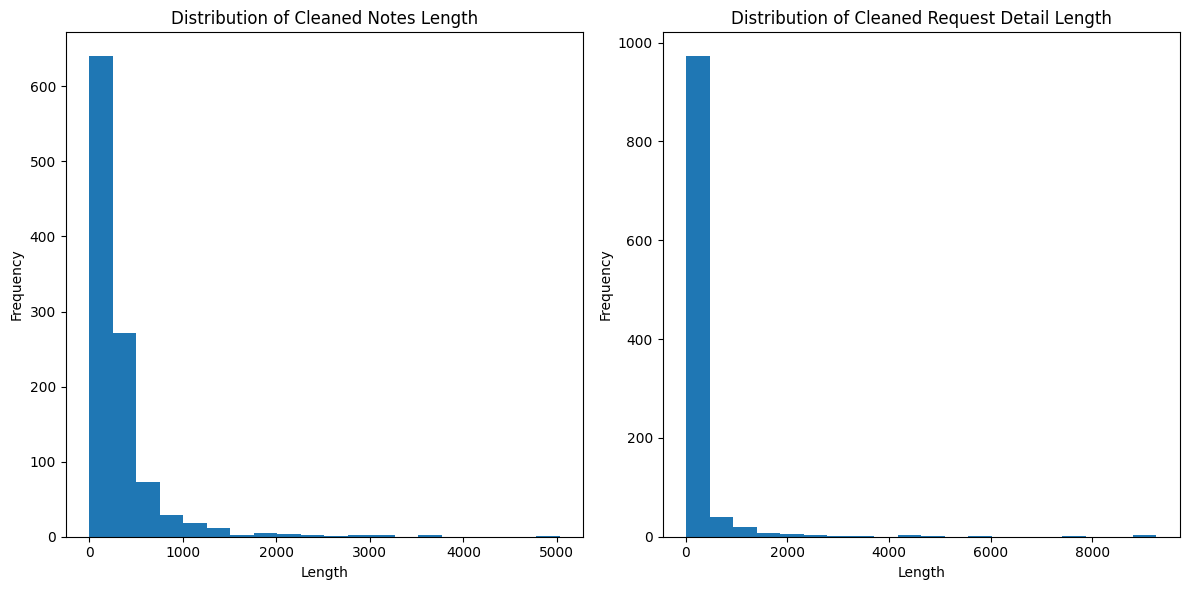


Correlation between Cleaned Notes Length and Cleaned Request Detail Length: 0.05007601425291344


In [18]:
# analyze length of cleaned notes and requests

# Calculate the length of cleaned notes and requests
df['Cleaned Notes Length'] = df['Cleaned Notes'].str.len()
df['Cleaned Request Detail Length'] = df['Cleaned Request Detail'].str.len()

# Analyze the length distribution
print("Descriptive statistics for Cleaned Notes Length:")
print(df['Cleaned Notes Length'].describe())
print("\nDescriptive statistics for Cleaned Request Detail Length:")
print(df['Cleaned Request Detail Length'].describe())

# You can further analyze the length distribution with visualizations like histograms:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(df['Cleaned Notes Length'], bins=20)
plt.title('Distribution of Cleaned Notes Length')
plt.xlabel('Length')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(df['Cleaned Request Detail Length'], bins=20)
plt.title('Distribution of Cleaned Request Detail Length')
plt.xlabel('Length')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()



We create two subplots to show the distribution of cleaned notes length and cleaned request detail length.
This helps visually assess the spread of text lengths and identify any unusually long entries.

**Remove Extremely Long Entries:**
If some requests or notes are too long, they might skew the translation process. Here, we remove any records where the "Cleaned Notes" exceed 1500 characters or the "Cleaned Request Detail" exceeds 2000 characters.

In [19]:
# remove notes with length more than 1500 and requests with more than 2000

df = df[df['Cleaned Notes Length'] <= 1500]
df = df[df['Cleaned Request Detail Length'] <= 2000]


**Translation**

Once we have cleaned and filtered the text data, we can proceed with translation. The goal is to translate the Arabic content in both the `Cleaned Notes` and `Cleaned Request Detail` columns into English using a translation model. We use GoogleTranslator from the deep_translator library for this task.

In [ ]:
# Initialize the translator
translator = GoogleTranslator(source='auto', target='en')

# Function to translate
def translate_requests(text):

  translated_request = translator.translate(text.strip())

  return translated_request

# Apply the updated translation function to each row in the 'Cleaned Notes' column
df['Translated Notes'] = df['Cleaned Notes'].apply(translate_requests)
df['Translated Requests'] = df['Cleaned Request Detail'].apply(translate_requests)


In [21]:
# print 5 samples after translation

samples = df['Translated Notes'].sample(5).index

for index in samples:
  print("Translated Request:")
  print(df.loc[index, 'Translated Requests'])
  print("\nTranslated Notes:")
  print(df.loc[index, 'Translated Notes'])
  print("\n---\n")


Translated Request:
Team We are facing problem with our Oasis WIFI NETWORK PROBLEM WIFI PLEASE SOLVE IT AS SOON AS POSSIBLE THANKS YOU Best Regards

Translated Notes:
Please add your note below : Head of Networks and Infrastructure Department Lena AlMusayid  |  we have fixed the issue in Oasis WIFI and now working fine Regards Abdalla Fadl Network Engineer | Dears Please provide us with contact number to be able to work on this ticket Best Regards Mohamad Ali Network Wireless Engineer

---

Translated Request:
HP Printer Serial No VNC4F46111 Product No CE461A

Translated Notes:
Checked and found the printer is liquid damage and not repair able Physically damage is not covered in maintenance See the attached pic | checked and found no power in printer pull out the printer for repair

---

Translated Request:
Support team We have a printer problem at Ehealth department 1 Hardware Model : HP Laser Jet 600 2 Serial Number : CNE8H3P7Q1 3 Device Location : Emergency 4 Issue description : ton

In [23]:
df.to_excel('translated_data.xlsx', index=False)

## Label Generation

In this part of the process, labels are generated for the cleaned dataset using zero-shot learning models. The primary goal is to classify the support requests into predefined categories and determine whether the request is within the scope of the support team's responsibility.




Steps:

- **Model Used**:
  - **facebook/bart-large-mnli**: This model is chosen for its strong performance in zero-shot classification tasks. It can assign labels to text even without being trained specifically for those categories. We use it for two tasks:
    - Classifying the request type (e.g., Hardware Issue, Software Issue, etc.)
    - Determining if the request is in or out of support scope.

- **Why Zero-Shot Classification?**
  - Zero-shot learning allows for classification without having labeled training data, which is perfect for cases where new labels or tasks are introduced. Here, we don't need to manually label every instance.
  

**Task 1 (Issue Classification):**

- **Candidate Labels for Issue Classification**:
  - The model is given four candidate labels:
    - **Hardware Issue**
    - **Network Issue**
    - **Software Issue**
    - **Parts Replacement**

- **How the Model Works**:
  - We combine the cleaned request and notes into a single field (`Combined_Text`) for classification.
  - The model analyzes this combined text and predicts the most appropriate label out of the four provided.

In [12]:
# Initialize the zero-shot classification pipeline
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli",device = 'cuda')
candidate_labels = ["Hardware Issue", "Network Issue", "Software Issue", "Parts Replacement"]


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [5]:
# Combine the "Cleaned Request" and "Cleaned Notes" into a single text field
df['Combined_Text'] = "***Request: " + df['Translated Requests'].astype(str) + " ***Notes: " + df['Translated Notes'].astype(str)


In [15]:
def classify_issue(text):
    try:
        result = classifier(text, candidate_labels, multi_label=False)
        return result['labels'][0]  # Return the top predicted label
    except Exception as e:
        return "Uncategorized"


In [16]:
# Apply the classification function to the "Combined_Text" column
df['Labels'] = df['Combined_Text'].apply(classify_issue)


After assigning the labels, we can inspect the distribution to ensure the model is producing reasonable results.

In [17]:
label_counts = df['Labels'].value_counts()
print(label_counts)

Labels
Hardware Issue       406
Network Issue        357
Parts Replacement    221
Software Issue        36
Name: count, dtype: int64


In [36]:
# show 5 samples from each class

for label in df['Labels'].unique():
  print(f"Samples for label: {label}")
  samples = df[df['Labels'] == label].sample(5)
  for index, row in samples.iterrows():
    print(f"  - Request: {row['Translated Requests'][:250]}... Notes: {row['Translated Notes'][:250]}...")
  print("-" * 50)


Samples for label: Hardware Issue
  - Request: Dear Al-Moammar Company, We are sending you a request to secure 6 keyboards and 6 mice.... Notes: The parts have been delivered, thank you....
  - Request: Support team We have a problem with PC doesnt work Serial Number : BTH4C03 Hardware Model : DELL Device Location :Financial Assistant Issue description : Giving powers to download the bramGiving software download powers Hospital Name : rain Hospital ... Notes: we have fixed the PC issue and working fine now Regards Abdalla Fadl Network Engineer...
  - Request: Support team We have an issue with one Smart Remote Control: 1 Hardware Model : Samsung RMCSPN1AP1 2 Serial Number : 1804120ADYQY 3 Device Location : IT Department 4 Issue description : Smart Remote Control Not Work 5 Hospital Name : Riyadh Al Khabra... Notes: Dear Sirs, Riyadh Al-Khubra Hospital, we would like to inform you that work is underway to provide the required part. Thank you Eng. Rashed...
  - Request: Asalamualikum We 

**Task 2 (Determining Scope):**

A second task is performed to determine whether a support request is within or outside the support scope.
Candidate Labels:
* **"This request is within the support scope."**
* **"This request is outside the support scope."**

In [37]:

# Initialize the zero-shot classification pipeline with XLM-Roberta
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli",device = 'cuda')

# Define the candidate labels
candidate_labels = [
    "This request is within the support scope.",
    "This request is outside the support scope."
]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [38]:
def classify_scope_llm_with_prompt(text):
    try:
        result = classifier(text, candidate_labels, multi_label=False)
        return result['labels'][0]  # Return the top predicted label
    except Exception as e:
        return "Uncategorized"


In [39]:
# Apply the classification function to the "Combined_Text" column
df['Scope_Label'] = df['Combined_Text'].apply(classify_scope_llm_with_prompt)


In [42]:
df['Scope_Label'].value_counts()

,count
Scope_Label,
This request is within the support scope.,979
This request is outside the support scope.,41


In [41]:
# show 5 samples from each class

for label in df['Scope_Label'].unique():
  print(f"Samples for label: {label}")
  samples = df[df['Scope_Label'] == label].sample(5)
  for index, row in samples.iterrows():
    print(f"  - Request: {row['Translated Requests'][:250]}... Notes: {row['Translated Notes'][:250]}...")
  print("-" * 50)


Samples for label: This request is within the support scope.
  - Request: Support Team Good day Please find the below device info and take prompt action to fix it or replace asap for the necessary need Model HP LASERJET P1102 SN VNF4K76385 Device location IT Issue description NOT WORKING Hospital name King Saud Hospital Th... Notes: Dears King Saud Hospital Good day As schedule the visit will be on 76 Regards Eng Rashed | Dears King Saud Hospital Good day The printer has been checked and the issue was in toner connector its solved and now its working fine Regards Eng Rashed...
  - Request: Support team We have a problem with PC Windows and RAM Serial Number :5q8ryb Hardware Model : HP Device Location : Issue description : The computer needs RAM and an upgrade for Windows 10 Hospital Name : AlQuwayiyah Hospital Contact Mobile Number : S... Notes: Dear Sirs, Al-Quwayiyah Hospital, we are pleased to communicate with you and we would like to inform you that the company’s contract does not 

**Label Mapping:**
Once the labels are generated using the zero-shot model, we map them to numerical values for easier analysis and model training later on.

In [63]:

# Define the labels - You may have two tasks, one for 'Issue Type' and one for 'Scope'
issue_label_mapping = {
    "Hardware Issue": 0,
    "Network Issue": 1,
    "Software Issue": 2,
    "Parts Replacement": 3
}

scope_label_mapping = {
    "This request is within the support scope.": 0,
    "This request is outside the support scope.": 1
}

# Map the labels to numerical values
df['Issue_Label'] = df['Labels'].map(issue_label_mapping)
df['Scope_Label'] = df['Scope_Label'].map(scope_label_mapping)


# Show the prepared data
df[['Combined_Text', 'Issue_Label', 'Scope_Label']].head()


,Combined_Text,Issue_Label,Scope_Label
0,***Request: We would like to inform you that t...,0,0
1,***Request: From: Ahmed Ibrahim Mohammed Alhai...,3,0
2,"***Request: Dear Al-Moammar Company, we are pl...",3,0
3,***Request: Some parts of the device need to b...,3,0
4,***Request: To the esteemed Al-Moammar Company...,2,0


## Supervised Classification

In this section, we focus on building a supervised classification pipeline using both traditional machine learning models and more advanced transformer-based models. Initially, we will apply classical models like **Logistic Regression** and **XGBoost** on the transformed text data, followed by the integration of pretrained transformer models.


1. **Classical Models**:
   - We will first train and evaluate traditional classifiers like **Logistic Regression** and **XGBoost**.
2. **Advanced Models**:
   - Then, we will experiment with more advanced pretrained transformers (e.g., BERT) to leverage contextual information in the text.

---

#### 1. Classical Models

To begin, we first vectorize the textual data to make it suitable for traditional machine learning models:

#### Key Steps:
- **Vectorization**:
  - **Count Vectorizer**: Converts text into a matrix of token counts.
  - **TF-IDF (Term Frequency-Inverse Document Frequency)**: Adjusts the frequency of terms to account for their relevance in the document.
  
#### Apply the following steps:
- **Step 1**: Create vector counts using `CountVectorizer`.
- **Step 2**: Transform word vectors into TF-IDF.
- **Step 3**: Split the data into training and testing sets using `train_test_split` on the TF-IDF and labels.


In [64]:
df_clean = df[['Combined_Text', 'Issue_Label', 'Scope_Label']]

**Checking for class imbalance**

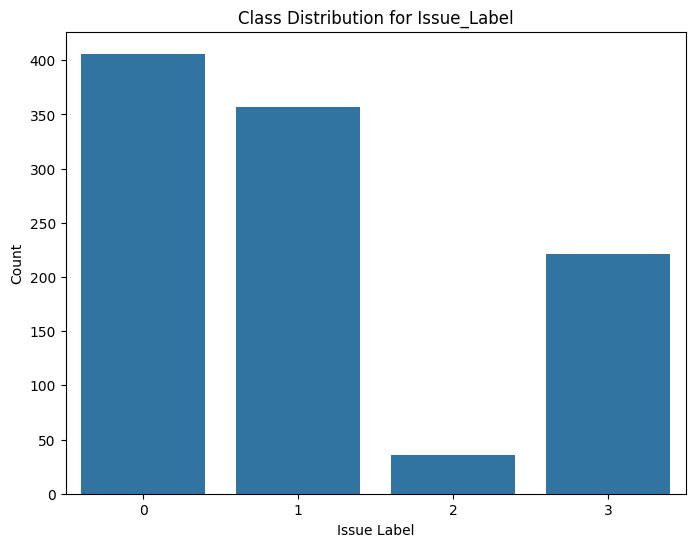

In [ ]:
#plot class dist for ['Issue_Label']

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
sns.countplot(x='Issue_Label', data=df_clean)
plt.title('Class Distribution for Issue_Label')
plt.xlabel('Issue Label')
plt.ylabel('Count')
plt.show()


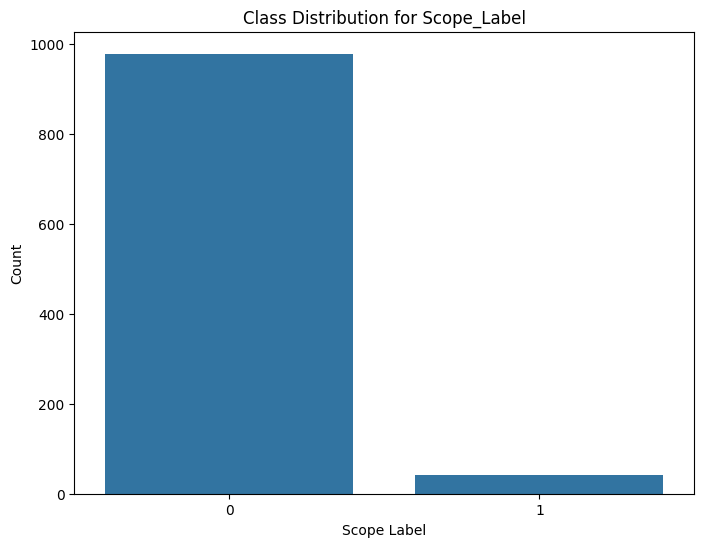

In [ ]:
# plot class dist for ['Scope']

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
sns.countplot(x='Scope_Label', data=df_clean)
plt.title('Class Distribution for Scope_Label')
plt.xlabel('Scope Label')
plt.ylabel('Count')
plt.show()


**As class imbalance is present in the data in a severe way. So, SMOTE will be applied on training data.**


In [83]:

# Step 1: Split the data into training and testing sets
train_X, test_X, train_y, test_y = train_test_split(df_clean['Combined_Text'], df_clean['Scope_Label'],stratify=df_clean['Scope_Label'], test_size=0.2, random_state=42)

# Step 2: Vectorize the text using CountVectorizer and TfidfTransformer
count_vectorizer = CountVectorizer()
tfidf_transformer = TfidfTransformer()

# Fit and transform the training data
train_counts = count_vectorizer.fit_transform(train_X)
train_tfidf = tfidf_transformer.fit_transform(train_counts)

# Transform the test data
test_counts = count_vectorizer.transform(test_X)
test_tfidf = tfidf_transformer.transform(test_counts)



In [84]:
# Perform SMOTE on training data

smote = SMOTE(random_state=42)
train_X_resampled, train_y_resampled = smote.fit_resample(train_tfidf, train_y)

print(f"Before SMOTE: {Counter(train_y)}")
print(f"After SMOTE: {Counter(train_y_resampled)}")


Before SMOTE: Counter({0: 783, 1: 33})
After SMOTE: Counter({0: 783, 1: 783})


We will try 3 models on the train & test data from these options:
* Logistic regression
* Random Forest
* XGboost

**Using the required evaluation metrics, we judge the tried models and select the ones performing the best**

In [85]:
# function to evaluate the model and display the results
def eval_model(y_test,y_pred,y_pred_proba,type='Training'):
    print(type,'results')
    print('Accuracy: ', accuracy_score(y_test,y_pred))
    print('Precision: ', precision_score(y_test,y_pred,average='weighted'))
    print('Recall: ', recall_score(y_test,y_pred,average='weighted'))
    print('F1 Score: ', f1_score(y_test,y_pred,average='weighted'))
    print('Classification Report: ', classification_report(y_test,y_pred))
    cm = confusion_matrix(y_test,y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=df_clean['Scope_Label'].unique())
    disp.plot()

In [86]:

# function to grid search the best parameters for the model
def run_model(model,param_grid):
    cv=StratifiedKFold(n_splits=5,shuffle=True,random_state=40)
    grid=GridSearchCV(model,param_grid=param_grid,cv=cv,scoring='f1_weighted',verbose=2,n_jobs=-1)
    grid.fit(train_X_resampled,train_y_resampled)
    return grid.best_estimator_

#### 1.  Logistic Regression

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Training results
Accuracy:  0.9968071519795658
Precision:  0.9968274111675126
Recall:  0.9968071519795658
F1 Score:  0.9968071194304521
Classification Report:                precision    recall  f1-score   support

           0       1.00      0.99      1.00       783
           1       0.99      1.00      1.00       783

    accuracy                           1.00      1566
   macro avg       1.00      1.00      1.00      1566
weighted avg       1.00      1.00      1.00      1566

Test results
Accuracy:  0.9754901960784313
Precision:  0.972844615233028
Recall:  0.9754901960784313
F1 Score:  0.9727552169845545
Classification Report:                precision    recall  f1-score   support

           0       0.98      0.99      0.99       196
           1       0.80      0.50      0.62         8

    accuracy                           0.98       204
   macro avg       0.89      0.75      0.80       204
weighted avg       0.97

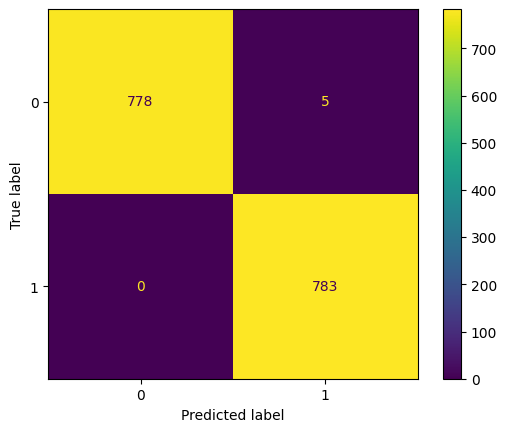

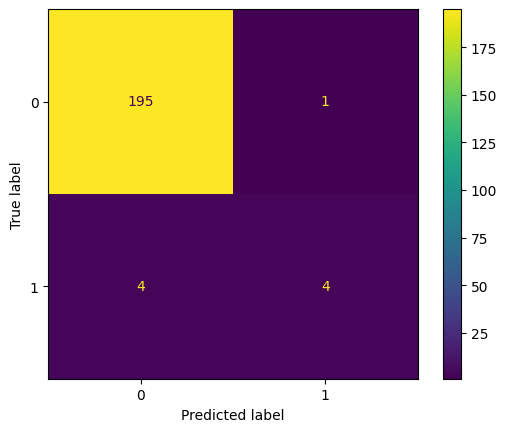

In [87]:
#running and evaluating the Logistic Regression model
params = {
    'C': [0.1, 1, 10],
    'penalty': [ 'l2', 'elasticnet'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'max_iter': [100, 200, 300],
    'class_weight': [None, 'balanced']
}
model=run_model(LogisticRegression(),params)
eval_model(train_y_resampled,model.predict(train_X_resampled),model.predict_proba(train_X_resampled),type='Training')
eval_model(test_y,model.predict(test_tfidf),model.predict_proba(test_tfidf),type='Test')

#### 2.  XGBoost

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Training results
Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1 Score:  1.0
Classification Report:                precision    recall  f1-score   support

           0       1.00      1.00      1.00       783
           1       1.00      1.00      1.00       783

    accuracy                           1.00      1566
   macro avg       1.00      1.00      1.00      1566
weighted avg       1.00      1.00      1.00      1566

Test results
Accuracy:  0.9607843137254902
Precision:  0.9607843137254902
Recall:  0.9607843137254902
F1 Score:  0.9607843137254902
Classification Report:                precision    recall  f1-score   support

           0       0.98      0.98      0.98       196
           1       0.50      0.50      0.50         8

    accuracy                           0.96       204
   macro avg       0.74      0.74      0.74       204
weighted avg       0.96      0.96      0.96       204



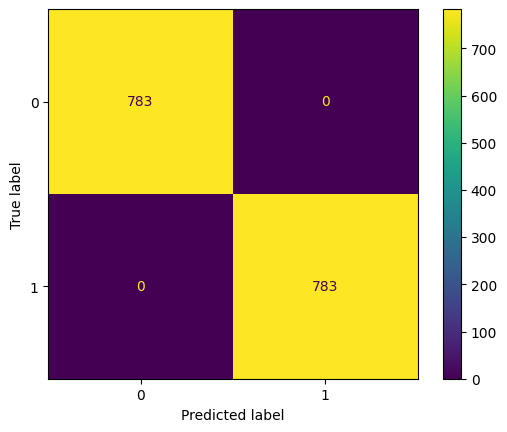

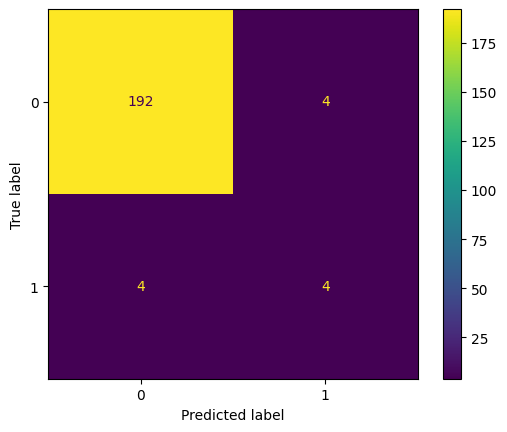

In [88]:
#running and evaluating the XGBoost model
params = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, 7],

}
model=run_model(XGBClassifier(),params)
eval_model(train_y_resampled,model.predict(train_X_resampled),model.predict_proba(train_X_resampled),type='Training')
eval_model(test_y,model.predict(test_tfidf),model.predict_proba(test_tfidf),type='Test')

### Transformers


In this section, we will use transformer models to handle the classification tasks. Specifically, we will use **BERT** to classify the issue type and scope of the requests. This is a powerful approach because transformer-based models are known to capture deep contextual information in text.

**Step 1: Tokenization**

First, we need to tokenize the text using the **BertTokenizer**, which converts the text into a format that BERT can process.


In [18]:

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the data
def tokenize_texts(texts):
    return tokenizer(texts.tolist(), padding=True, truncation=True, max_length=512, return_tensors="pt")



**Step 2: Dataset Preparation**

We split the data into training and validation sets for the two tasks: Issue_Label and Scope_Label classification. We also define a custom dataset class that will be used for training.

In [24]:

# Define the labels - You may have two tasks, one for 'Issue Type' and one for 'Scope'
issue_label_mapping = {
    "Hardware Issue": 0,
    "Network Issue": 1,
    "Software Issue": 2,
    "Parts Replacement": 3
}

scope_label_mapping = {
    "This request is within the support scope.": 0,
    "This request is outside the support scope.": 1
}

# Map the labels to numerical values
df_clean['Issue_Label'] = df_clean['Labels'].map(issue_label_mapping)
df_clean['Scope_Label'] = df_clean['Scope_Label'].map(scope_label_mapping)

**Step 3: Model Training for Issue_Label Classification**

We use the BertForSequenceClassification model and the Trainer class from the transformers library to fine-tune the BERT model on our classification task.

In [ ]:
train_texts, val_texts, train_issue_labels, val_issue_labels = train_test_split(
    df_clean['Combined_Text'],
    df_clean['Issue_Label'],
    test_size=0.2,
    random_state=42
)

class TicketDataset(Dataset):
    def __init__(self, encodings, labels, sample_weights=None):
        self.encodings = encodings
        self.labels = labels
        self.sample_weights = sample_weights

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Function to tokenize texts
def tokenize_texts(texts):
    # Example using Hugging Face's tokenizer
    from transformers import AutoTokenizer
    tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
    return tokenizer(list(texts), padding=True, truncation=True, return_tensors='pt')

# Function for computing metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=-1)

    # Precision, Recall, F1-Score
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')

    # Compute metrics
    return {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "accuracy": accuracy_score(labels, predictions)
    }

# Tokenize the training and validation texts
train_encodings = tokenize_texts(train_texts)
val_encodings = tokenize_texts(val_texts)

# Compute class weights
classes = np.unique(train_issue_labels)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=train_issue_labels
)
class_weights_dict = {cls: weight for cls, weight in zip(classes, class_weights)}

In [39]:



print("Class Weights:", class_weights_dict)

# Assign weights to each sample
sample_weights = [class_weights_dict[label] for label in train_issue_labels]
sample_weights = torch.tensor(sample_weights, dtype=torch.double)

# Create the dataset with sample_weights
train_dataset = TicketDataset(train_encodings, train_issue_labels.tolist(), sample_weights=sample_weights)
val_dataset = TicketDataset(val_encodings, val_issue_labels.tolist())

# Define a custom Trainer that uses WeightedRandomSampler
class CustomTrainer(Trainer):
    def get_train_dataloader(self):
        # Ensure sample_weights are present
        if not hasattr(self.train_dataset, 'sample_weights'):
            raise AttributeError("The training dataset must have a 'sample_weights' attribute.")

        # Create the WeightedRandomSampler
        sampler = WeightedRandomSampler(
            weights=self.train_dataset.sample_weights,
            num_samples=len(self.train_dataset),
            replacement=True
        )

        return DataLoader(
            self.train_dataset,
            batch_size=self.args.train_batch_size,
            sampler=sampler
        )

# Load a pre-trained BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(classes))

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',              # Output directory for checkpoints and results
    num_train_epochs=10,                 # Number of training epochs
    per_device_train_batch_size=8,       # Batch size per device during training
    per_device_eval_batch_size=8,        # Batch size for evaluation
    warmup_steps=500,                    # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,                   # Strength of weight decay
    logging_dir='./logs',                # Directory for storing logs
    evaluation_strategy="epoch",         # Evaluate every epoch
    save_strategy="epoch",               # Save the model at the end of each epoch
    load_best_model_at_end=True,         # Load the best model (with the least validation loss) at the end of training
    metric_for_best_model="eval_loss",    # Use validation loss to determine the best model
    save_total_limit=2                    # Save only the last two checkpoints to save disk space
)

# Initialize the CustomTrainer
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()


Class Weights: {0: 0.6335403726708074, 1: 0.7183098591549296, 2: 6.580645161290323, 3: 1.1396648044692737}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,1.147686,0.653486,0.607843,0.609332,0.607843
2,No log,0.628375,0.766080,0.750000,0.754305,0.750000
3,No log,0.636408,0.778708,0.735294,0.743466,0.735294
4,No log,0.677688,0.808486,0.754902,0.763775,0.754902
5,0.693100,0.654000,0.837389,0.823529,0.828362,0.823529
6,0.693100,0.780337,0.835064,0.823529,0.827328,0.823529
7,0.693100,0.822073,0.840048,0.838235,0.836911,0.838235
8,0.693100,0.831264,0.849345,0.838235,0.841598,0.838235
9,0.693100,0.928083,0.843272,0.833333,0.836449,0.833333
10,0.159200,0.897621,0.861142,0.852941,0.855607,0.852941


TrainOutput(global_step=1020, training_loss=0.41788001282177134, metrics={'train_runtime': 867.7659, 'train_samples_per_second': 9.403, 'train_steps_per_second': 1.175, 'total_flos': 2147024765583360.0, 'train_loss': 0.41788001282177134, 'epoch': 10.0})

In [54]:
# Evaluate the model on the validation set
eval_results = trainer.evaluate()

# Print the evaluation results (including accuracy)
print(f"Validation Accuracy: {eval_results['eval_accuracy']:.4f}")


Validation Accuracy: 0.7500


**Step 4: Scope_Label Classification**

Next, we repeat the process for classifying whether the request is within or outside the scope of support.




In [42]:
# Split dataset for the second task: Scope_Label classification
train_texts_scope, val_texts_scope, train_scope_labels, val_scope_labels = train_test_split(
    df_clean['Combined_Text'], df_clean['Scope_Label'], test_size=0.2, random_state=42, stratify =df_clean['Scope_Label'] )



train_encodings_scope = tokenize_texts(train_texts_scope)
val_encodings_scope = tokenize_texts(val_texts_scope)


In [43]:

class SingleTaskDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Create datasets for Scope_Label classification
train_dataset_scope = SingleTaskDataset(train_encodings_scope, train_scope_labels.tolist())
val_dataset_scope = SingleTaskDataset(val_encodings_scope, val_scope_labels.tolist())


In [44]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=-1)

    # Precision, Recall, F1-Score
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')

    # Compute metrics
    return {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "accuracy": accuracy_score(labels, predictions)
    }

In [45]:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments

# Define the model for Scope_Label classification (2 classes)
model_scope = BertForSequenceClassification.from_pretrained('google-bert/bert-base-multilingual-cased', num_labels=2)

# Define training arguments for Scope_Label
training_args = TrainingArguments(
    output_dir='./results_scope',    # Output directory for checkpoints and results
    num_train_epochs=10,             # Number of training epochs
    per_device_train_batch_size=8,   # Batch size per device during training
    per_device_eval_batch_size=8,    # Batch size for evaluation
    warmup_steps=500,                # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # Strength of weight decay
    logging_dir='./logs_scope',      # Directory for storing logs
    evaluation_strategy="epoch",     # Evaluate every epoch
    save_strategy="epoch",           # Save the model at the end of each epoch
    load_best_model_at_end=True,     # Load the best model (with the least validation loss) at the end of training
    metric_for_best_model="eval_loss", # Use validation loss to determine the best model
    save_total_limit=2               # Save only the last two checkpoints to save disk space
)

# Define the Trainer for Scope_Label
trainer_scope = Trainer(
    model=model_scope,
    args=training_args,
    train_dataset=train_dataset_scope,
    eval_dataset=val_dataset_scope,
    compute_metrics=compute_metrics
)

# Train the model for Scope_Label
trainer_scope.train()

# Evaluate the model for Scope_Label
eval_results_scope = trainer_scope.evaluate()

# Print the accuracy for Scope_Label
print(f"Scope Classification Accuracy: {eval_results_scope['eval_accuracy']:.4f}")


config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.192590,0.923106,0.960784,0.941569,0.960784
2,No log,0.175692,0.923106,0.960784,0.941569,0.960784
3,No log,0.162551,0.923106,0.960784,0.941569,0.960784
4,No log,0.195981,0.923106,0.960784,0.941569,0.960784
5,0.208200,0.179087,0.923106,0.960784,0.941569,0.960784
6,0.208200,0.169404,0.923106,0.960784,0.941569,0.960784
7,0.208200,0.173090,0.923106,0.960784,0.941569,0.960784
8,0.208200,0.177511,0.923106,0.960784,0.941569,0.960784
9,0.208200,0.173591,0.923106,0.960784,0.941569,0.960784
10,0.192800,0.175003,0.923106,0.960784,0.941569,0.960784


Scope Classification Accuracy: 0.9608


**Confusion Matrix**

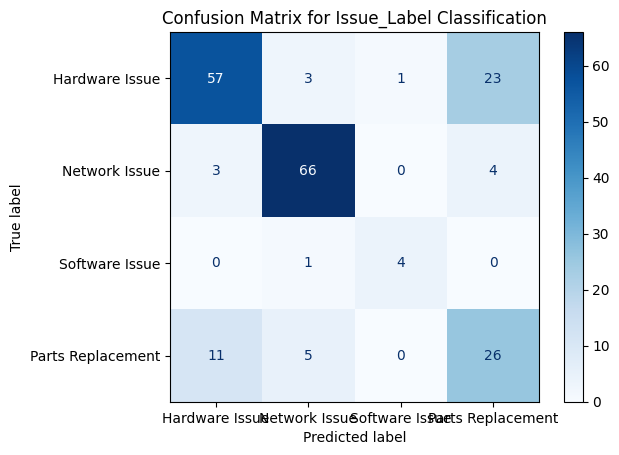

Issue_Label Classification:
Accuracy: 0.7500
Precision: 0.7661
Recall: 0.7500
F1 Score: 0.7543

Classification Report for Issue_Label:
                   precision    recall  f1-score   support

   Hardware Issue       0.80      0.68      0.74        84
    Network Issue       0.88      0.90      0.89        73
   Software Issue       0.80      0.80      0.80         5
Parts Replacement       0.49      0.62      0.55        42

         accuracy                           0.75       204
        macro avg       0.74      0.75      0.74       204
     weighted avg       0.77      0.75      0.75       204



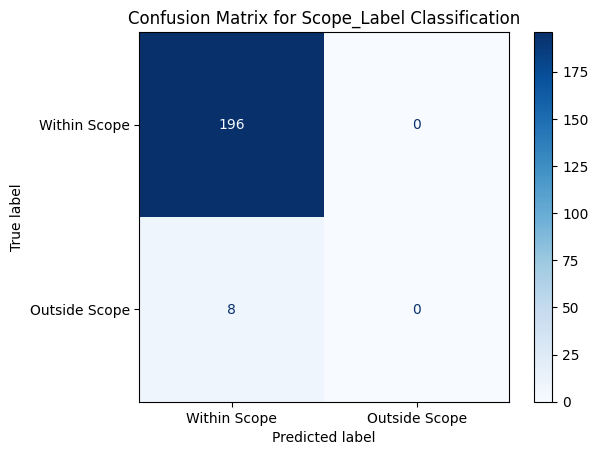

Scope_Label Classification:
Accuracy: 0.9608
Precision: 0.9231
Recall: 0.9608
F1 Score: 0.9416

Classification Report for Scope_Label:
               precision    recall  f1-score   support

 Within Scope       0.96      1.00      0.98       196
Outside Scope       0.00      0.00      0.00         8

     accuracy                           0.96       204
    macro avg       0.48      0.50      0.49       204
 weighted avg       0.92      0.96      0.94       204



In [79]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# For Issue_Label classification
# Get the predictions for the validation set
issue_predictions = trainer.predict(val_dataset)
predicted_issue_labels = np.argmax(issue_predictions.predictions, axis=1)

# Compute the confusion matrix
issue_conf_matrix = confusion_matrix(val_issue_labels, predicted_issue_labels)

# Display the confusion matrix
ConfusionMatrixDisplay(confusion_matrix=issue_conf_matrix, display_labels=['Hardware Issue', 'Network Issue', 'Software Issue', 'Parts Replacement']).plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Issue_Label Classification")
plt.show()

# Calculate accuracy, precision, recall, and F1 score for Issue_Label
issue_accuracy = accuracy_score(val_issue_labels, predicted_issue_labels)
issue_precision = precision_score(val_issue_labels, predicted_issue_labels, average='weighted')
issue_recall = recall_score(val_issue_labels, predicted_issue_labels, average='weighted')
issue_f1 = f1_score(val_issue_labels, predicted_issue_labels, average='weighted')

print(f"Issue_Label Classification:\nAccuracy: {issue_accuracy:.4f}\nPrecision: {issue_precision:.4f}\nRecall: {issue_recall:.4f}\nF1 Score: {issue_f1:.4f}")
print("\nClassification Report for Issue_Label:")
print(classification_report(val_issue_labels, predicted_issue_labels, target_names=['Hardware Issue', 'Network Issue', 'Software Issue', 'Parts Replacement']))


# For Scope_Label classification
# Get the predictions for the validation set
scope_predictions = trainer_scope.predict(val_dataset_scope)
predicted_scope_labels = np.argmax(scope_predictions.predictions, axis=1)

# Compute the confusion matrix
scope_conf_matrix = confusion_matrix(val_scope_labels, predicted_scope_labels)

# Display the confusion matrix
ConfusionMatrixDisplay(confusion_matrix=scope_conf_matrix, display_labels=['Within Scope', 'Outside Scope']).plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Scope_Label Classification")
plt.show()

# Calculate accuracy, precision, recall, and F1 score for Scope_Label
scope_accuracy = accuracy_score(val_scope_labels, predicted_scope_labels)
scope_precision = precision_score(val_scope_labels, predicted_scope_labels, average='weighted')
scope_recall = recall_score(val_scope_labels, predicted_scope_labels, average='weighted')
scope_f1 = f1_score(val_scope_labels, predicted_scope_labels, average='weighted')

print(f"Scope_Label Classification:\nAccuracy: {scope_accuracy:.4f}\nPrecision: {scope_precision:.4f}\nRecall: {scope_recall:.4f}\nF1 Score: {scope_f1:.4f}")
print("\nClassification Report for Scope_Label:")
print(classification_report(val_scope_labels, predicted_scope_labels, target_names=['Within Scope', 'Outside Scope']))


## Topic Modelling

**Why Topic Modeling?**

Topic modeling is an unsupervised learning technique that helps us discover the underlying themes or topics present in a large corpus of text.

### Lemmatization

Let's start by applying further cleaning and lemmatizing the text data in preparation for BERTopic.

In [ ]:
def clean_text(text):
  text=text.lower()  #convert to lower case
  text=re.sub(r'^\[[\w\s]\]+$',' ',text) #Remove text in square brackets
  text=re.sub(r'[^\w\s]',' ',text) #Remove punctuation
  text=re.sub(r'^[a-zA-Z]\d+\w*$',' ',text) #Remove words with numbers
  text=re.sub(r'\d',' ',text)   #Remove numbers
  text=re.sub(r'\s+',' ',text) #Remove extra spaces
  text=re.sub(r'\b[a-zA-Z]\b','',text)   #Remove signle chars
  return text

In [ ]:
#unction to Lemmatize the texts
stopwords = nlp.Defaults.stop_words
def lemmatization(texts):
    lemma_sentences = []
    for doc in tqdm(nlp.pipe(texts)):
        sent = [token.lemma_ for token in doc if token.text not in set(stopwords)]
        lemma_sentences.append(' '.join(sent))
    return lemma_sentences

In [ ]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints
df_clean = pd.DataFrame()

In [ ]:
# Clean text columns
df_clean['Combined_Text'] = df['Combined_Text'].progress_apply(lambda x: clean_text(x))


100%|██████████| 1020/1020 [00:00<00:00, 6290.45it/s]


In [ ]:
# lemmitize the text columns
df_clean['Lemmatized Text'] = lemmatization(df_clean['Combined_Text'])

1020it [00:17, 59.01it/s]


### EDA

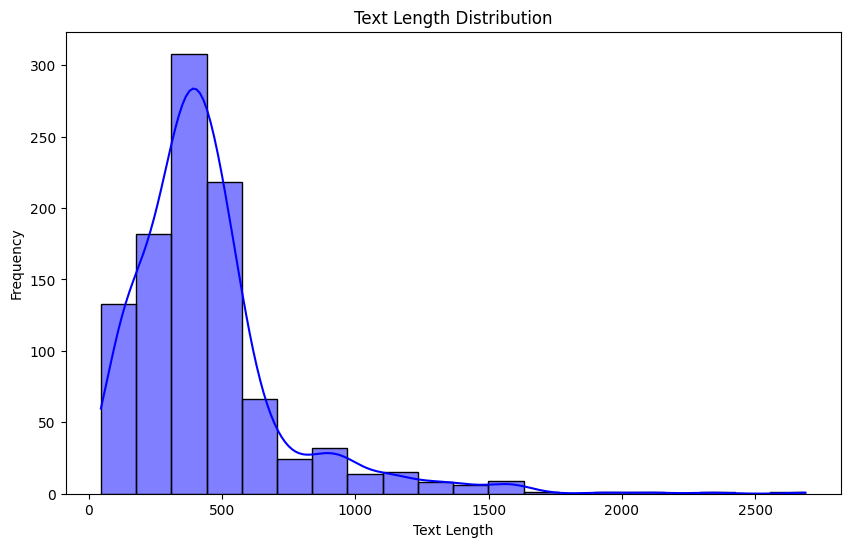

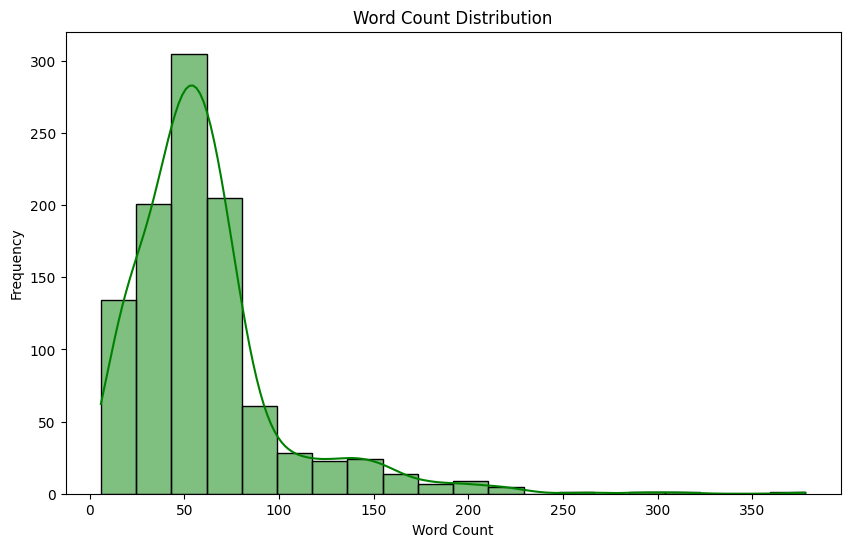

In [190]:
import seaborn as sns
import matplotlib.pyplot as plt

# Basic statistics on text length and word count
df_clean['text_length'] = df_clean['Lemmatized Text'].apply(len)  # Length of the text
df_clean['word_count'] = df_clean['Lemmatized Text'].apply(lambda x: len(x.split()))  # Number of words

# Plot text length distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_clean['text_length'], bins=20, kde=True, color='blue')
plt.title('Text Length Distribution')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

# Plot word count distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_clean['word_count'], bins=20, kde=True, color='green')
plt.title('Word Count Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()


Plot top 100 frequent words

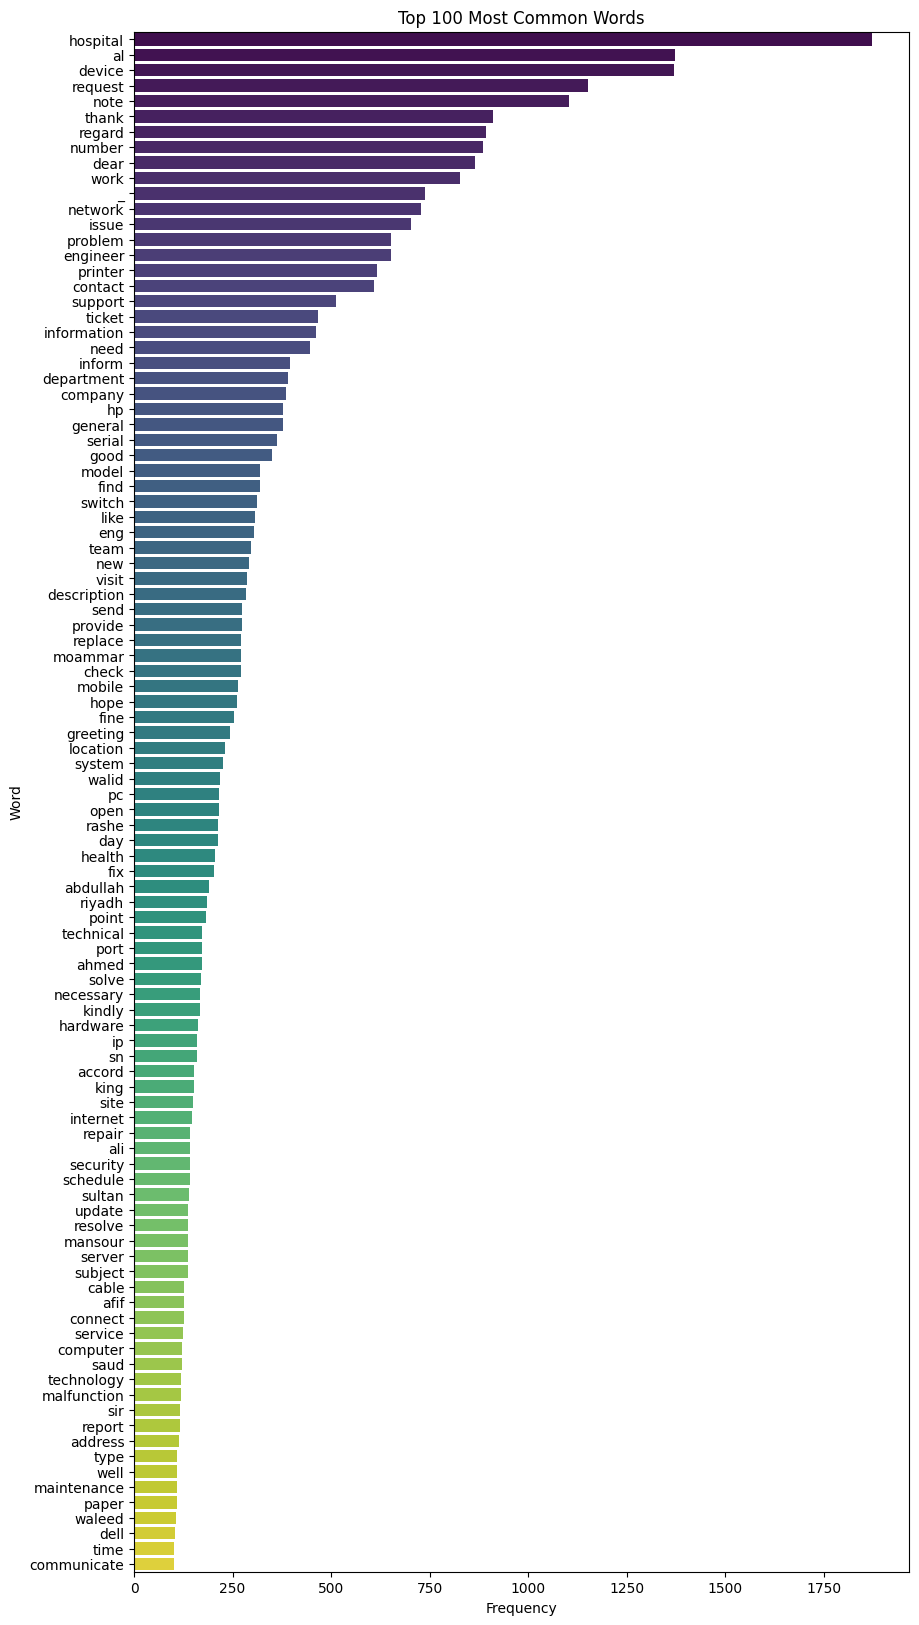

['hospital',
 'al',
 'request',
 'note',
 'thank',
 'regard',
 'number',
 'dear',
 '_',
 'engineer']

In [217]:

# Tokenize the combined text column
all_words = ' '.join(df_clean['Lemmatized Text']).split()

# Count word frequency
word_counts = Counter(all_words)
most_common_words = word_counts.most_common(100)

# Convert to DataFrame for visualization
word_df = pd.DataFrame(most_common_words, columns=['Word', 'Frequency'])

# Plot word frequency
plt.figure(figsize=(10, 20))
sns.barplot(x='Frequency', y='Word', data=word_df, palette='viridis')
plt.title('Top 100 Most Common Words')
plt.show()


Many words are irrelevant such as names (abdullah, ahmed), hospital and many others. We will manually create a list of them and ommit them.

In [220]:
import re

# List of words to exclude
to_exclude = ['hospital', 'al','request','note','thank','regard','number','dear','_','engineer',
              'like','eng','greeting','walid','rashe','day','abdullah','nyadh','ahmed','ali','king',
              'sultan','mansour','saud','waleed','sir','afif']

# Create a regex pattern to excluded list
pattern = re.compile(r'\b(' + '|'.join(to_exclude) + r')\b', re.IGNORECASE)

# Function to remove names based on name list and regex
def remove_excluded_regex(text):
    return pattern.sub('', text).strip()



In [221]:
df_clean['Lemmatized Text'] = df_clean['Lemmatized Text'].apply(remove_excluded_regex)

In [30]:
# change the display properties of pandas to max
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

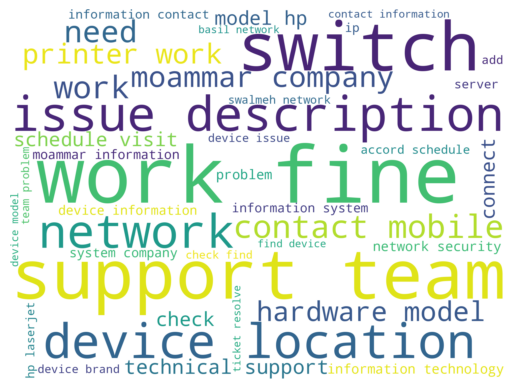

In [223]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
wordcloud=WordCloud(stopwords=stopwords, background_color='white', width=2000, height=1500,max_words=40).generate(' '.join(df_clean['Lemmatized Text']))
plt.imshow(wordcloud, interpolation='bilinear', aspect='auto')
plt.axis("off")
plt.show()

### BERTopic

Let's move to the implementation part of BERTopic:

In [3]:
import pandas as pd
df_clean =  pd.read_excel('final_df.xlsx')

In [11]:
from bertopic import BERTopic
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP

# Prepare the KMeans model
kmeans_model = KMeans(n_clusters=5, random_state=42)  # Set the number of clusters

# Set UMAP parameters for dimensionality reduction
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine')

# Initialize BERTopic with KMeans as the clustering model
topic_model = BERTopic(
    umap_model=umap_model,  # Use UMAP for dimensionality reduction
    hdbscan_model=kmeans_model,  # Replace HDBSCAN with KMeans
    n_gram_range=(1, 2),  # Use unigrams and bigrams
    min_topic_size=10,  # Minimum size of topics
    top_n_words=10,  # Number of top words to show per topic
)

# Prepare your lemmatized text data
docs = df_clean['Lemmatized Text'].tolist()

# Fit the model to your documents
topics, probabilities = topic_model.fit_transform(docs)


Visualization of Topics

BERTopic allows you to visualize the topics it has learned. The visualizations can include a variety of plots, including:

* **Topic Frequency:** To see how often each topic appears.
* **Topic Heatmaps:** To view relationships between topics.
* **Topic Hierarchies:** To observe the hierarchical structure of topics.

In [12]:
# Visualize the most frequent topics
topic_model.visualize_barchart(top_n_topics=10)

In [14]:


# Visualize the topic probabilities over time or by document
topic_model.visualize_topics()
